# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import data
import os
from astropy.table import Table, unique
from analysis_tools_cython import *
from tqdm import tqdm

---

### Functions

In [3]:
def get_output(file_path):
    """Imports batch_analyse output file as pandas dataframe."""
    with open(file_path) as f:
        lines = f.readlines()
    lc_lists = [word for line in lines for word in line.split()]
    lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]
    cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
    df = pd.DataFrame(data=lc_lists,columns=cols)
    df[cols[1:-1]] = df[cols[1:-1]].astype('float32')
    return df

def filter_df(df,min_asym_score=1.0,max_asym_score=2.0,duration=0.5,signal=-5.0):
    """filters df for given parameter range.
    Default settings:
    - `signal/noise` greater than 5.
        - Minimum test statistic is always negative. We flip the sign in plots for convenience.
    - `duration` set to greater than 0.5 days.
    - `asym_score` between 1.00 to 2.0.
    """
    return df[(df.duration >= duration) & (df['signal/noise'] <= signal) & (df['asym_score'] >= min_asym_score) & (df['asym_score'] <= max_asym_score)]

def distribution(x,y):
    """plots asymmetry score vs signal/noise over a signal of 5"""
    fig,ax = plt.subplots(figsize=(10,7))
    ax.scatter(x,y,s=1)
    ax.set_xlim(-0,1.9)
    ax.set_ylim(5,30)
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('$S$')
    fig.tight_layout()


---

## Creating DataFrame
- data initially used is `corrected flux`, not PCA.

In [4]:
df = get_output('output_s6_corr.txt')
filtered_df = filter_df(df)

In [5]:
df['transit_prob'].unique()

array(['end', 'point', 'maybeTransit', 'artefact'], dtype=object)

`filtered_df` with `maybeTransit` only

In [6]:
filtered_df[filtered_df.transit_prob == 'maybeTransit']

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
74,tesslc_358107514.pkl,-16.146212,-7.903914,1476.509888,1.204875,0.276562,0.008221,0.562491,-0.020073,maybeTransit
125,tesslc_52372424.pkl,-18.709896,-6.779119,1473.412476,1.077338,0.001386,0.332484,0.562488,-0.055661,maybeTransit
171,tesslc_349057825.pkl,-6.521335,-6.049706,1475.427734,1.020258,0.256052,0.011278,0.583341,-0.003638,maybeTransit
396,tesslc_47393158.pkl,-14.532734,-6.099787,1473.412354,1.066261,0.037819,0.305712,0.562485,-0.029245,maybeTransit
846,tesslc_282914898.pkl,-13.306834,-6.231078,1476.036743,1.019741,0.387593,0.082091,0.708344,-0.009215,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
2778387,tesslc_120388852.pkl,-10.836166,-5.565127,1476.140869,1.005058,0.376889,0.079474,0.708341,-0.002736,maybeTransit
2778420,tesslc_375149170.pkl,-12.067715,-5.599195,1476.095947,1.011910,0.508504,0.070825,1.083329,-0.000687,maybeTransit
2778441,tesslc_200605689.pkl,-12.399840,-6.451329,1473.412354,1.062864,0.029395,0.300459,0.541656,-0.004028,maybeTransit
2778811,tesslc_375179713.pkl,-12.247461,-6.171144,1475.259766,1.073656,0.046779,0.238998,0.520844,-0.003083,maybeTransit


---

### Raw Plot

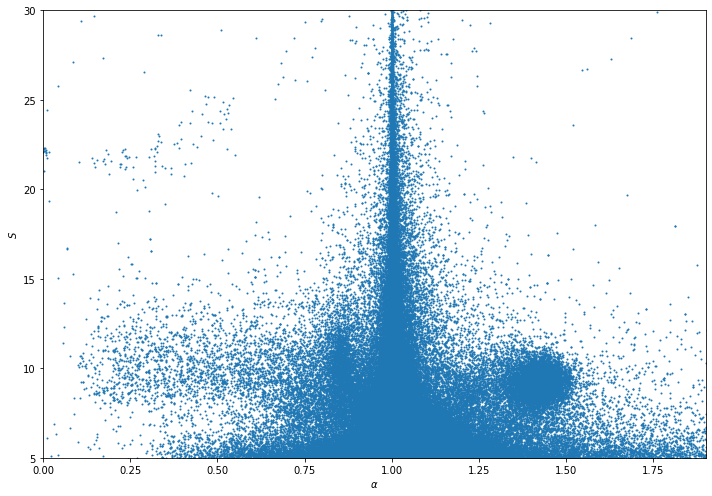

In [7]:
distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only

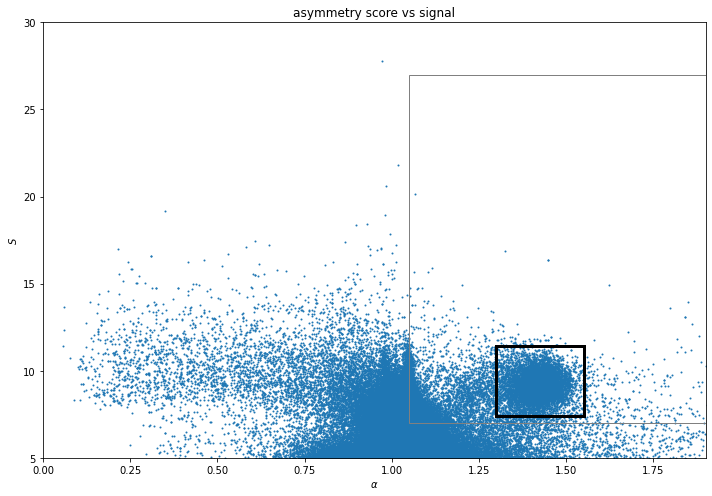

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')
ax.set_title('asymmetry score vs signal')
fig.tight_layout()
rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
ax.add_patch(rect)
ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

### Exploring that black boxed region (S6)

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [9]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [16]:
to_import = box['file']
#example = box['file'].tail(25)

---

In [12]:
sector = 6
clip = 4
path = '/storage/astro2/phrdhx/tesslcs'
mad_df = data.load_mad()

#### Saving TIC paths

In [13]:
# for i in tqdm(to_import):
#     file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
#     ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
#     store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[1]
#     tic = store[0]
#     ra = store[1]
#     dec = store[2]
#     to_export = [tic,ra,dec]
#     with open("weird_tic_path.txt", "a") as output:
#         output.write(file_paths+'\n')

---

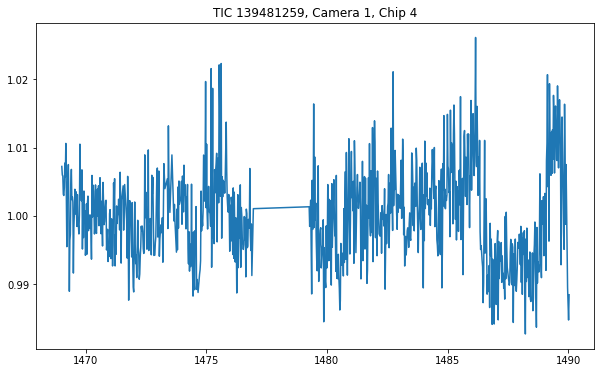

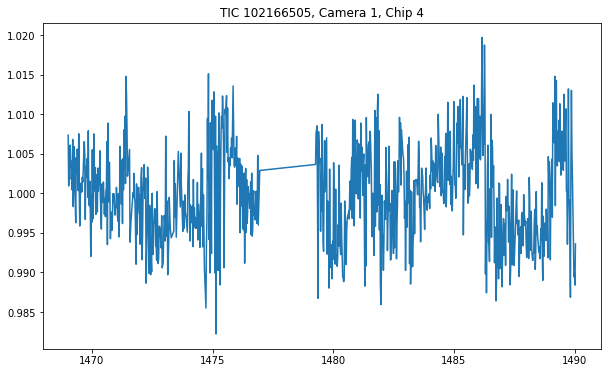

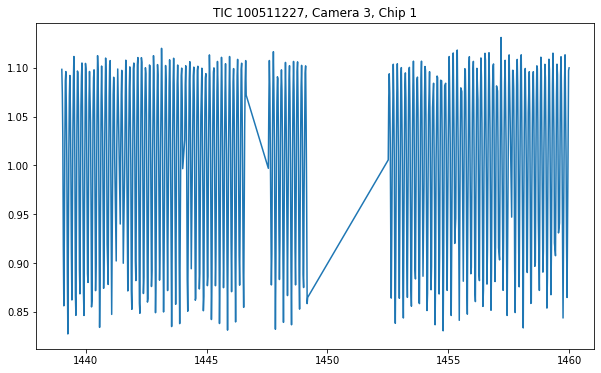

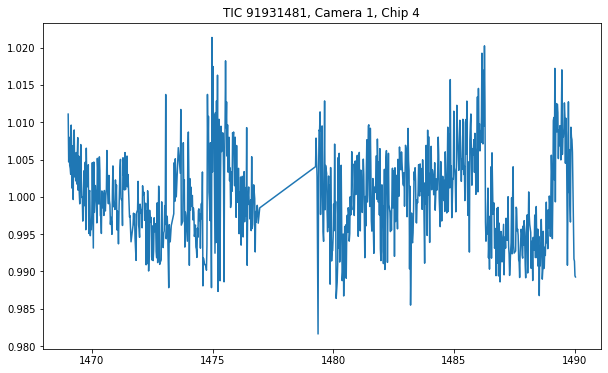

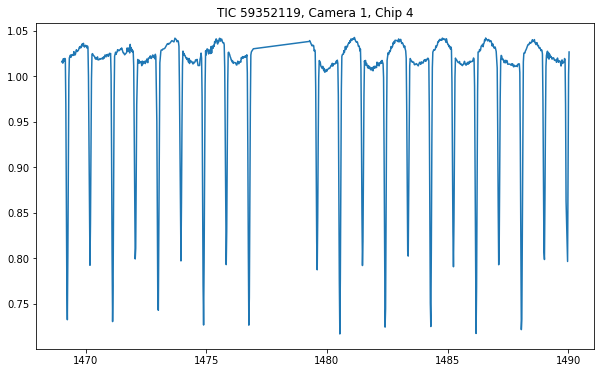

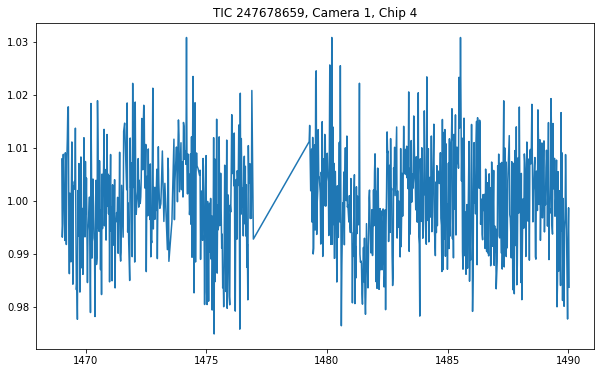

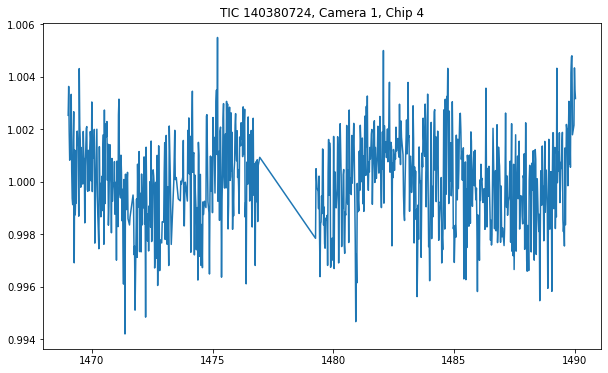

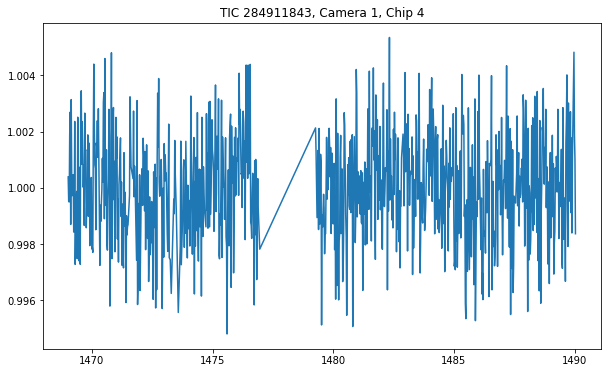

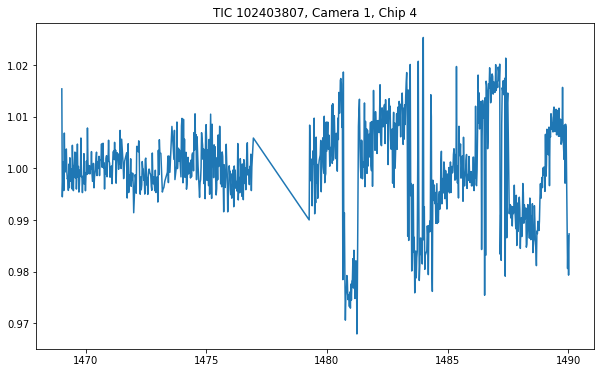

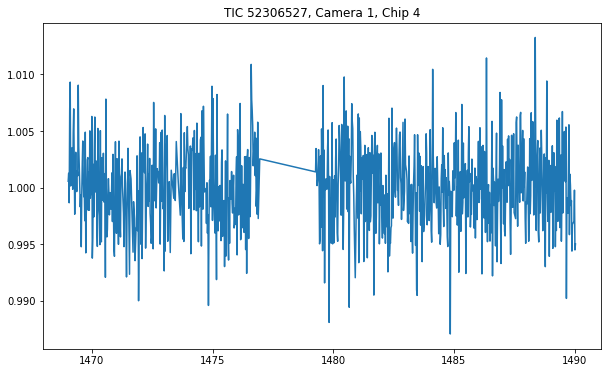

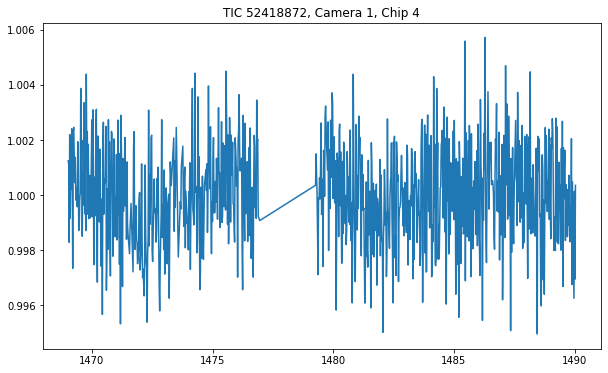

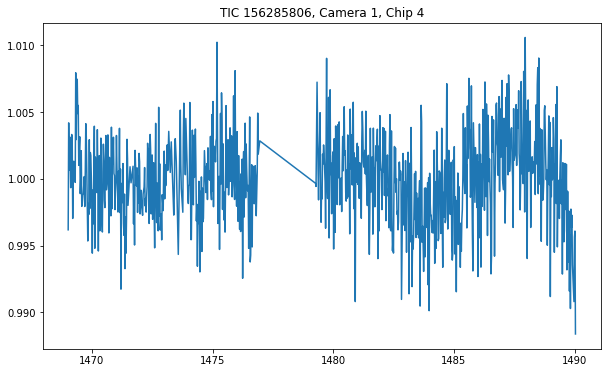

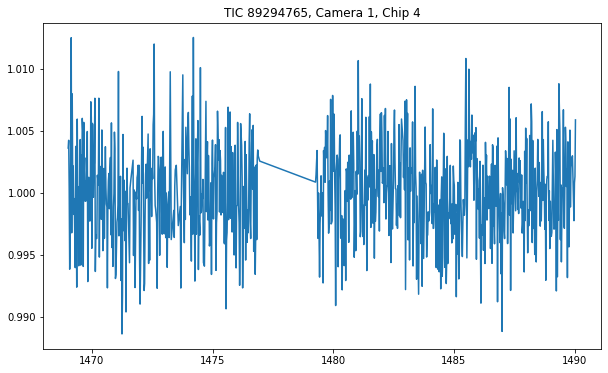

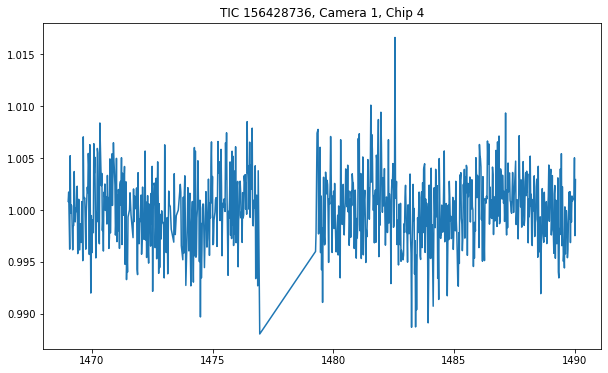

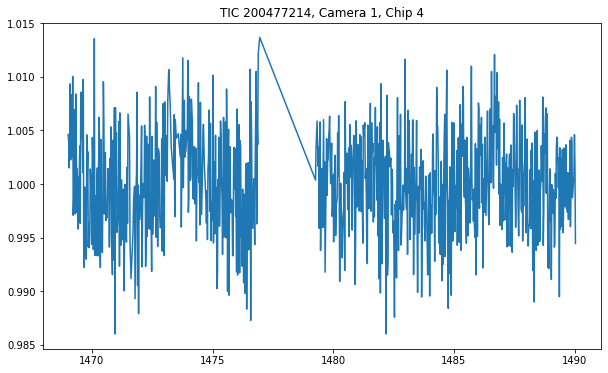

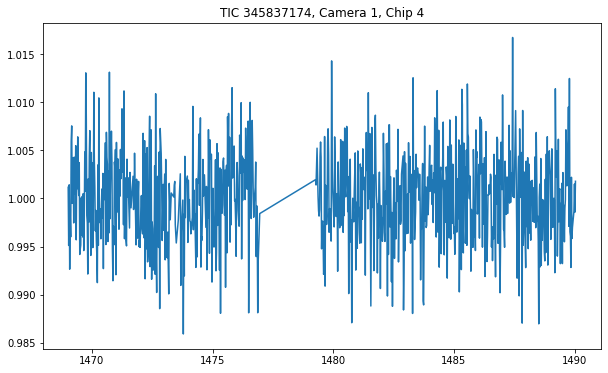

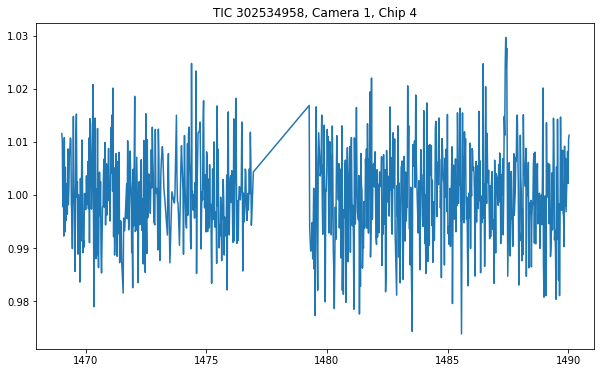

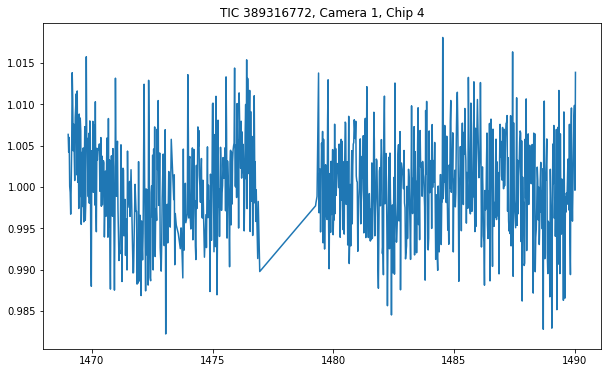

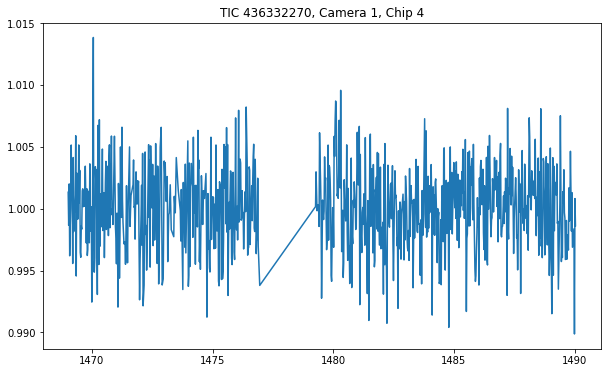

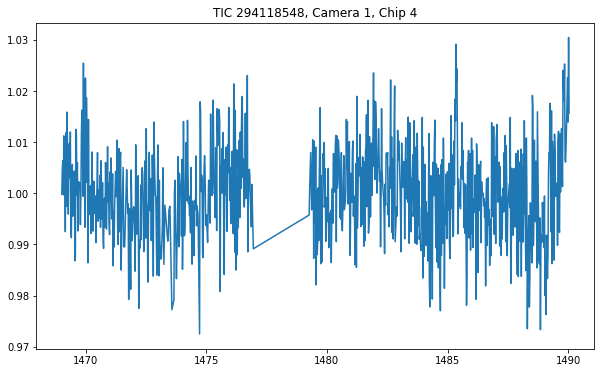

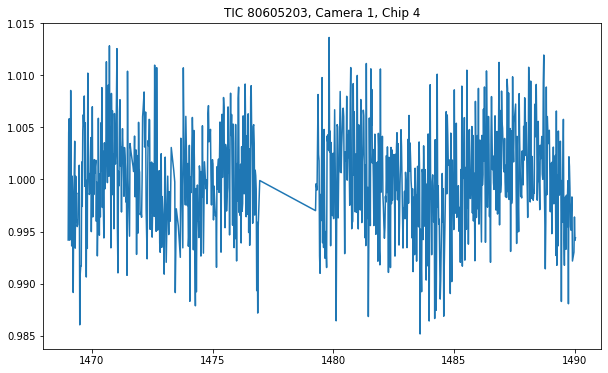

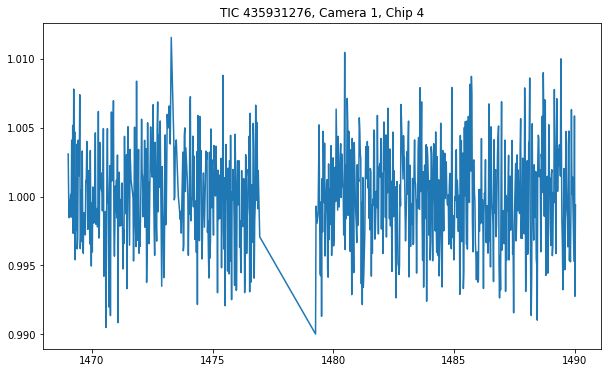

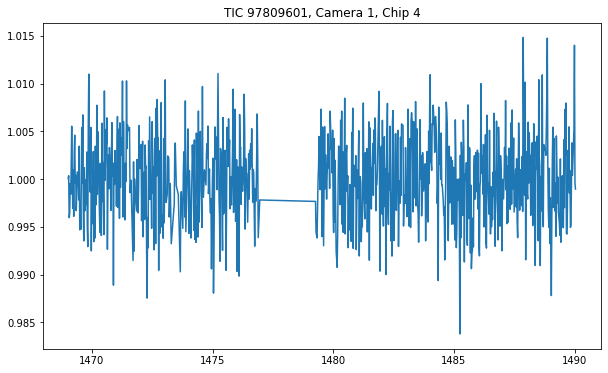

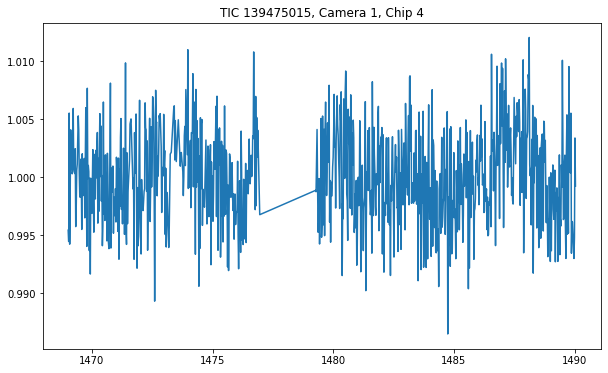

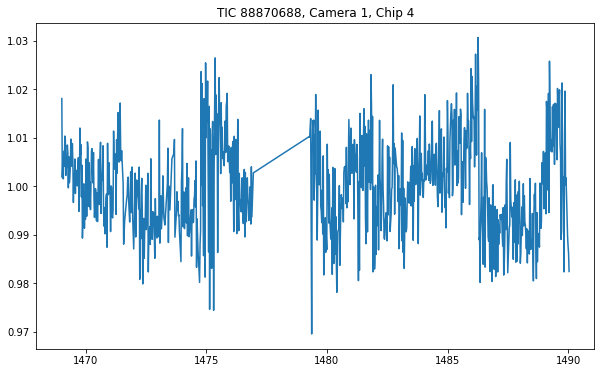

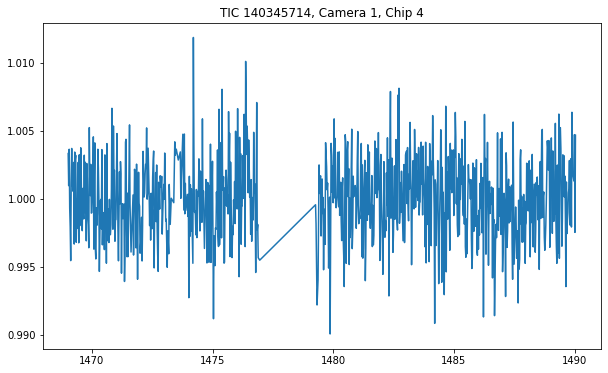

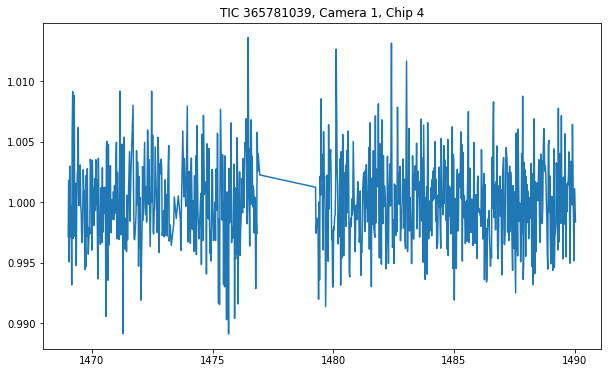

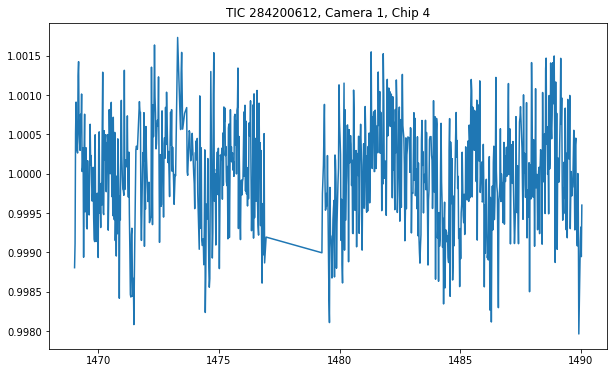

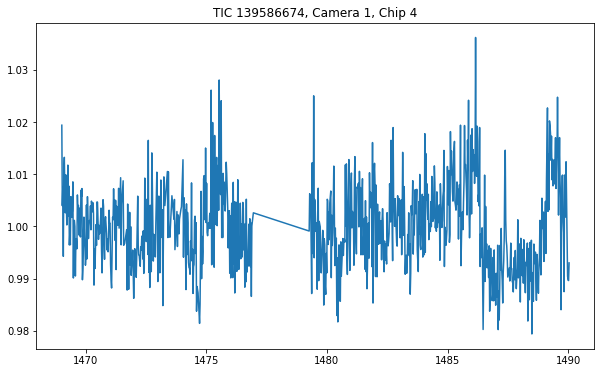

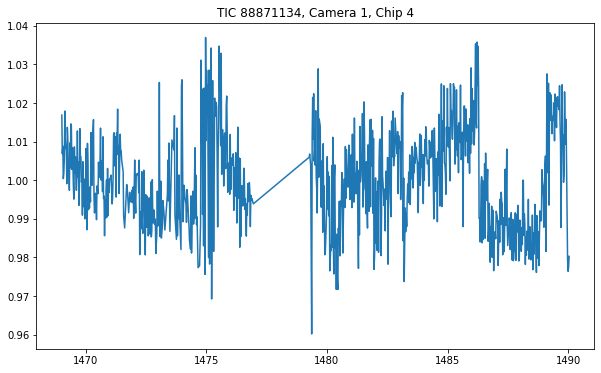

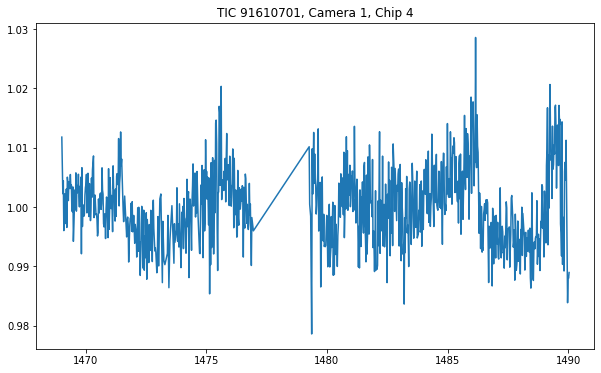

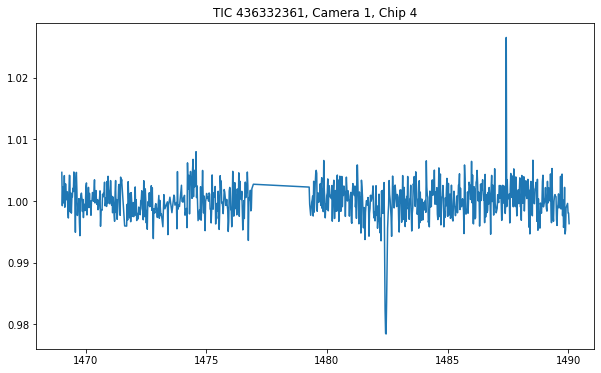

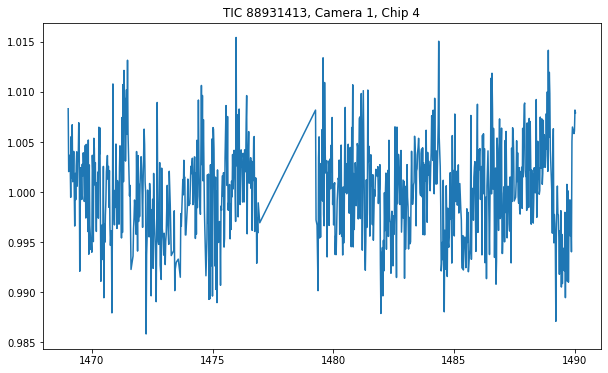

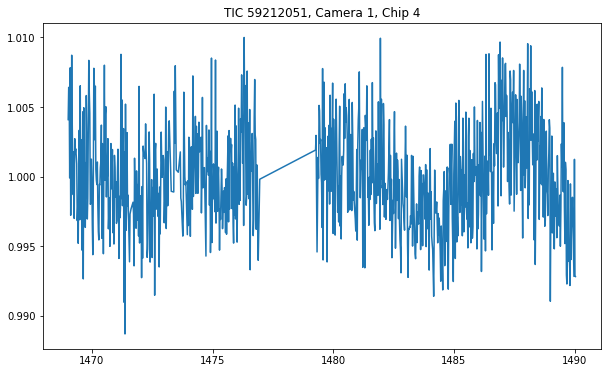

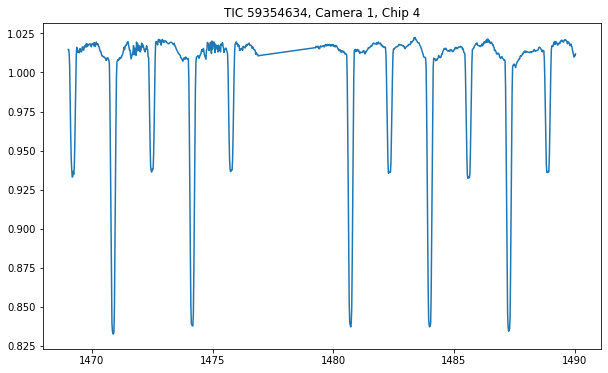

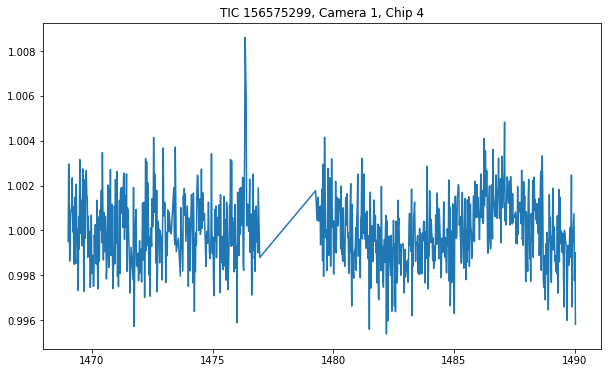

KeyboardInterrupt: 

In [17]:
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=True)[0]
    store = import_XRPlightcurve(file_paths,sector=sector)[1]
    camera = store[4]
    tic = store[0]
    chip = store[5]
    fig,ax = plt.subplots(1,figsize=(10,6))
    ax.set_title(f'TIC {tic}, Camera {camera}, Chip {chip}')
    ax.plot(table['time'],normalise_lc(table['PCA flux']))
    plt.show()
    
#     mad_arr = mad_df.loc[:len(table['time'])-1,f"{sector}-{camera}"]
#     sig_clip = sigma_clip(mad_arr,sigma=clip,masked=True)
#     med_sig_clip = np.nanmedian(sig_clip)
#     rms_sig_clip = np.nanstd(sig_clip)
#     mad_cut = mad_arr.values < ~sig_clip.mask 
    

#     fig, ax = plt.subplots(2,2,figsize=(10,8))
#     ax[0,1].scatter(table['time'], mad_arr, s=2)
#     ax[0,1].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].scatter(range(0,len(table['time'])), mad_arr, s=2)
#     ax[0,0].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].axhline(med_sig_clip + clip*rms_sig_clip, c='r')
#     ax[0,0].set_title(f'S{sector}-C{camera}')
#     plt.show()